<a href="https://colab.research.google.com/github/sowmya8900/HPCProject/blob/main/CUDA_PDE_Solvers.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!nvcc --version

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2024 NVIDIA Corporation
Built on Thu_Jun__6_02:18:23_PDT_2024
Cuda compilation tools, release 12.5, V12.5.82
Build cuda_12.5.r12.5/compiler.34385749_0


In [ ]:
!pip install git+https://github.com/andreinechaev/nvcc4jupyter.git

  Cloning https://github.com/andreinechaev/nvcc4jupyter.git to /tmp/pip-req-build-cxciifwe
  Running command git clone --filter=blob:none --quiet https://github.com/andreinechaev/nvcc4jupyter.git /tmp/pip-req-build-cxciifwe
  Resolved https://github.com/andreinechaev/nvcc4jupyter.git to commit 28f872a2f99a1b201bcd0db14fdbc5a496b9bfd7
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


In [ ]:
!pip install nvcc4jupyter==1.0.0

  Attempting uninstall: nvcc4jupyter
    Found existing installation: nvcc4jupyter 1.2.1
    Uninstalling nvcc4jupyter-1.2.1:
      Successfully uninstalled nvcc4jupyter-1.2.1


In [ ]:
%load_ext nvcc4jupyter

The nvcc4jupyter module is not an IPython extension.




---
Dummy codes to check if everything's working fine

---




In [ ]:
%%writefile add.cpp

#include <iostream>
#include <math.h>

// function to add the elements of two arrays
void add(int n, float *x, float *y)
{
  for (int i = 0; i < n; i++)
      y[i] = x[i] + y[i];
}

int main(void)
{
  int N = 1<<20; // 1M elements

  float *x = new float[N];
  float *y = new float[N];

  // initialize x and y arrays on the host
  for (int i = 0; i < N; i++) {
    x[i] = 1.0f;
    y[i] = 2.0f;
  }

  // Run kernel on 1M elements on the CPU
  add(N, x, y);

  // Check for errors (all values should be 3.0f)
  float maxError = 0.0f;
  for (int i = 0; i < N; i++)
    maxError = fmax(maxError, fabs(y[i]-3.0f));
  std::cout << "Max error: " << maxError << std::endl;

  // Free memory
  delete [] x;
  delete [] y;

  return 0;
}

Writing add.cpp


In [ ]:
%%shell
g++ add.cpp -o add

In [ ]:
%%shell
./add

Max error: 0


In [ ]:
%%writefile add.cu

#include <iostream>
#include <math.h>
// Kernel function to add the elements of two arrays
__global__
void add(int n, float *x, float *y)
{
  for (int i = 0; i < n; i++)
    y[i] = x[i] + y[i];
}

int main(void)
{
  int N = 1<<20
 ;
  float *x, *y;

  // Allocate Unified Memory – accessible from CPU or GPU
  cudaMallocManaged(&x, N*sizeof(float));
  cudaMallocManaged(&y, N*sizeof(float));

  // initialize x and y arrays on the host
  for (int i = 0; i < N; i++) {
    x[i] = 1.0f;
    y[i] = 2.0f;
  }

  // Run kernel on 1M elements on the GPU
  add<<<1, 1>>>(N, x, y);

  // Wait for GPU to finish before accessing on host
  cudaDeviceSynchronize();

  // Check for errors (all values should be 3.0f)
  float maxError = 0.0f;
  for (int i = 0; i < N; i++)
    maxError = fmax(maxError, fabs(y[i]-3.0f));
  std::cout << "Max error: " << maxError << std::endl;

  // Free memory
  cudaFree(x);
  cudaFree(y);

  return 0;
}

Writing add.cu


In [ ]:
%%shell
nvcc add.cu -o add_cu
./add_cu

Max error: 1


In [ ]:
%%shell
nvprof ./add_cu

==7315== NVPROF is profiling process 7315, command: ./add_cu
Max error: 1
==7315== Profiling application: ./add_cu
==7315== Profiling result:
No kernels were profiled.
            Type  Time(%)      Time     Calls       Avg       Min       Max  Name
      API calls:   92.85%  118.91ms         2  59.454ms  50.589us  118.86ms  cudaMallocManaged
                    6.65%  8.5197ms         1  8.5197ms  8.5197ms  8.5197ms  cudaLaunchKernel
                    0.30%  386.13us         2  193.06us  187.57us  198.56us  cudaFree
                    0.17%  211.67us       114  1.8560us     211ns  79.453us  cuDeviceGetAttribute
                    0.01%  15.985us         1  15.985us  15.985us  15.985us  cuDeviceGetName
                    0.01%  12.175us         1  12.175us  12.175us  12.175us  cudaDeviceSynchronize
                    0.00%  5.1340us         1  5.1340us  5.1340us  5.1340us  cuDeviceGetPCIBusId
                    0.00%  1.5600us         3     520ns     178ns  1.0240us  cuDeviceGet

In [ ]:
%%shell
nvidia-smi

Sun Mar 30 19:31:23 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   40C    P8             10W /   70W |       0MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

---
# Heat Solver
---

In [16]:
%%writefile heat.cu
#include <iostream>
#include <fstream>
#include <vector>
#include <cmath>
#include <cuda_runtime.h>
#include <chrono>

#define BLOCK_SIZE 8
#define gpuErrchk(ans) { gpuAssert((ans), __FILE__, __LINE__); }

inline void gpuAssert(cudaError_t code, const char *file, int line) {
    if (code != cudaSuccess) {
        fprintf(stderr, "GPUassert: %s %s %d\n", cudaGetErrorString(code), file, line);
        exit(code);
    }
}

__global__ void updateGridKernel(double* u, double* u_new, int grid_size, double coeff) {
    int i = blockIdx.x * blockDim.x + threadIdx.x;
    int j = blockIdx.y * blockDim.y + threadIdx.y;
    int k = blockIdx.z * blockDim.z + threadIdx.z;

    if (i > 0 && i < grid_size - 1 &&
        j > 0 && j < grid_size - 1 &&
        k > 0 && k < grid_size - 1) {

        int idx = i * grid_size * grid_size + j * grid_size + k;
        u_new[idx] = u[idx] + coeff * (
            u[idx + grid_size * grid_size] +  // i+1
            u[idx - grid_size * grid_size] +  // i-1
            u[idx + grid_size] +              // j+1
            u[idx - grid_size] +              // j-1
            u[idx + 1] +                      // k+1
            u[idx - 1] -                      // k-1
            6.0 * u[idx]);
    }
}

/*
void initializeGrid(double* u, int grid_size, double initial_value) {
    std::fill(u, u + grid_size * grid_size * grid_size, initial_value);
    int center = grid_size / 2;
    int radius = 5;

    for (int i = center - radius; i <= center + radius; ++i) {
        for (int j = center - radius; j <= center + radius; ++j) {
            for (int k = center - radius; k <= center + radius; ++k) {
                double r = sqrt(pow(i - center, 2) + pow(j - center, 2) + pow(k - center, 2));
                if (r <= radius) {
                    u[i * grid_size * grid_size + j * grid_size + k] = initial_value * 2.0;
                }
            }
        }
    }
}
*/

void initializeGrid(double* u, int grid_size, double initial_value) {
    std::fill(u, u + grid_size * grid_size * grid_size, initial_value);

    // Set hot boundaries
    for (int i = 0; i < grid_size; i++) {
        for (int j = 0; j < grid_size; j++) {
            for (int k = 0; k < grid_size; k++) {
                if (i == 0 || i == grid_size-1 ||
                    j == 0 || j == grid_size-1 ||
                    k == 0 || k == grid_size-1) {
                    u[i*grid_size*grid_size + j*grid_size + k] = initial_value * 2.0;
                }
            }
        }
    }
}

// multi-source heat solver initialization
/*
void initializeGrid(double* u, int grid_size, double initial_value) {
    std::fill(u, u + grid_size*grid_size*grid_size, initial_value);

    // Add three heat sources
    int centers[3][3] = {{10,10,10}, {30,30,30}, {10,30,40}}; // x,y,z positions
    for (auto& c : centers) {
        for (int i=c[0]-5; i<=c[0]+5; ++i)
            for (int j=c[1]-5; j<=c[1]+5; ++j)
                for (int k=c[2]-5; k<=c[2]+5; ++k)
                    if (i>=0 && i<grid_size && j>=0 && j<grid_size && k>=0 && k<grid_size)
                        u[i*grid_size*grid_size + j*grid_size + k] = initial_value * 2.0;
    }
}
*/

void saveResults(const double* u, int grid_size, const std::string& filename) {
    std::ofstream file(filename);
    if (!file) {
        std::cerr << "Error opening file: " << filename << "\n";
        return;
    }

    for (int i = 0; i < grid_size; ++i) {
        for (int j = 0; j < grid_size; ++j) {
            for (int k = 0; k < grid_size; ++k) {
                file << i << " " << j << " " << k << " "
                     << u[i * grid_size * grid_size + j * grid_size + k] << "\n";
            }
        }
    }
    file.close();
}

int main() {
    const int grid_size = 50;
    const double alpha = 0.01;
    const double dx = 1.0;
    const double dt = 0.9 * (dx * dx) / (6.0 * alpha);
    const double coeff = alpha * dt / (dx * dx);
    const int total_steps = 1000;
    const int save_interval = 100;  // Save every 100 steps

    // Allocate host memory
    double* h_u = new double[grid_size * grid_size * grid_size];
    double* h_u_new = new double[grid_size * grid_size * grid_size];
    double* h_temp = new double[grid_size * grid_size * grid_size];  // For copying

    // Initialize grid
    initializeGrid(h_u, grid_size, 100.0);
    std::copy(h_u, h_u + grid_size * grid_size * grid_size, h_u_new);

    // Allocate device memory
    double *d_u, *d_u_new;
    gpuErrchk(cudaMalloc(&d_u, grid_size * grid_size * grid_size * sizeof(double)));
    gpuErrchk(cudaMalloc(&d_u_new, grid_size * grid_size * grid_size * sizeof(double)));

    // Copy to device
    gpuErrchk(cudaMemcpy(d_u, h_u, grid_size * grid_size * grid_size * sizeof(double),
                         cudaMemcpyHostToDevice));
    gpuErrchk(cudaMemcpy(d_u_new, h_u_new, grid_size * grid_size * grid_size * sizeof(double),
                         cudaMemcpyHostToDevice));

    // Configure kernel launch
    dim3 threadsPerBlock(BLOCK_SIZE, BLOCK_SIZE, BLOCK_SIZE);
    dim3 numBlocks((grid_size + threadsPerBlock.x - 1) / threadsPerBlock.x,
                   (grid_size + threadsPerBlock.y - 1) / threadsPerBlock.y,
                   (grid_size + threadsPerBlock.z - 1) / threadsPerBlock.z);

    // Warm-up kernel
    updateGridKernel<<<numBlocks, threadsPerBlock>>>(d_u, d_u_new, grid_size, coeff);
    gpuErrchk(cudaDeviceSynchronize());

    // Time measurement
    auto start = std::chrono::high_resolution_clock::now();

    for (int t = 0; t < total_steps; ++t) {
        updateGridKernel<<<numBlocks, threadsPerBlock>>>(d_u, d_u_new, grid_size, coeff);
        std::swap(d_u, d_u_new);

        // Save intermediate results
        if (t % save_interval == 0) {
            gpuErrchk(cudaMemcpy(h_temp, d_u, grid_size * grid_size * grid_size * sizeof(double),
                             cudaMemcpyDeviceToHost));
            saveResults(h_temp, grid_size, "heat_step_" + std::to_string(t) + ".txt");
        }
    }
    gpuErrchk(cudaDeviceSynchronize());

    auto end = std::chrono::high_resolution_clock::now();
    std::chrono::duration<double> elapsed = end - start;
    std::cout << "Simulation time: " << elapsed.count() << " seconds\n";

    // Save final results
    gpuErrchk(cudaMemcpy(h_u, d_u, grid_size * grid_size * grid_size * sizeof(double),
                         cudaMemcpyDeviceToHost));
    saveResults(h_u, grid_size, "heat_final.txt");

    // Cleanup
    delete[] h_u;
    delete[] h_u_new;
    delete[] h_temp;
    gpuErrchk(cudaFree(d_u));
    gpuErrchk(cudaFree(d_u_new));

    return 0;
}

Overwriting heat.cu


In [17]:
!nvcc -O3 -arch=sm_70 -o heat_solver heat.cu
!./heat_solver

Simulation time: 0.988152 seconds


In [18]:
!nvprof ./heat_solver

==6777== NVPROF is profiling process 6777, command: ./heat_solver
Simulation time: 0.990054 seconds
==6777== Profiling application: ./heat_solver
==6777== Profiling result:
            Type  Time(%)      Time     Calls       Avg       Min       Max  Name
 GPU activities:   98.11%  55.587ms      1001  55.531us  53.278us  58.174us  updateGridKernel(double*, double*, int, double)
                    1.60%  904.49us        11  82.226us  77.598us  88.030us  [CUDA memcpy DtoH]
                    0.30%  168.25us         2  84.126us  84.094us  84.158us  [CUDA memcpy HtoD]
      API calls:   58.41%  86.774ms         2  43.387ms  5.0220us  86.769ms  cudaMalloc
                   32.74%  48.635ms        13  3.7411ms  227.28us  5.2729ms  cudaMemcpy
                    5.26%  7.8187ms      1001  7.8100us  5.4650us  136.22us  cudaLaunchKernel
                    3.32%  4.9264ms         2  2.4632ms  59.392us  4.8670ms  cudaDeviceSynchronize
                    0.17%  250.45us         2  125.22us  38

---
# Visualization
---

In [ ]:
%%writefile visualize_heat_cuda.py
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from skimage import measure
import os
import glob

def load_heat_data(filename, grid_size=50):
    """Load 3D heat data from solver output"""
    data = np.loadtxt(filename)
    # Reshape into 3D grid (i,j,k,value)
    u = data[:, 3].reshape((grid_size, grid_size, grid_size))
    return u

def plot_2d_slices(u, save_path=None):
    """Plot XY, XZ, and YZ slices through the 3D data"""
    fig, axes = plt.subplots(1, 3, figsize=(18, 6))

    # Middle indices for slices
    mid_x, mid_y, mid_z = u.shape[0]//2, u.shape[1]//2, u.shape[2]//2

    slices = {
        'XY Plane (Z=' + str(mid_z) + ')': u[:, :, mid_z],
        'XZ Plane (Y=' + str(mid_y) + ')': u[:, mid_y, :],
        'YZ Plane (X=' + str(mid_x) + ')': u[mid_x, :, :]
    }

    vmin, vmax = np.min(u), np.max(u)

    for ax, (title, slice_data) in zip(axes, slices.items()):
        im = ax.imshow(slice_data, cmap='hot', origin='lower',
                      vmin=vmin, vmax=vmax)
        ax.set_title(title)
        ax.set_xlabel('X' if 'Y' in title else 'Y')
        ax.set_ylabel('Y' if 'Z' in title else 'Z')
        fig.colorbar(im, ax=ax, label='Temperature')

    plt.tight_layout()
    if save_path:
        plt.savefig(save_path, dpi=150, bbox_inches='tight')
    plt.show()

def plot_3d_isosurface(u, save_path=None):
    """Create 3D isosurface plot of temperature"""
    fig = plt.figure(figsize=(10, 8))
    ax = fig.add_subplot(111, projection='3d')

    # Create grid
    x, y, z = np.mgrid[0:u.shape[0], 0:u.shape[1], 0:u.shape[2]]

    # Plot multiple isothermal surfaces
    levels = np.linspace(np.min(u), np.max(u), 6)[1:-1]

    for level in levels:
        verts, faces, _, _ = measure.marching_cubes(u, level=level)
        ax.plot_trisurf(verts[:, 0], verts[:, 1], faces, verts[:, 2],
                       cmap='hot', alpha=0.5, antialiased=True)

    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')
    ax.set_title('3D Isothermal Surfaces')

    if save_path:
        plt.savefig(save_path, dpi=150, bbox_inches='tight')
    plt.show()

def create_heat_animation(output_file="heat_diffusion.gif", grid_size=50):
    """Create animation from multiple time steps"""
    # Find all time step files
    files = sorted(glob.glob("heat_step_*.txt"),
                  key=lambda x: int(x.split('_')[2].split('.')[0]))

    if not files:
        print("No time step files found! Run the solver first.")
        return

    fig, ax = plt.subplots(figsize=(8, 6))

    # Load first frame to initialize
    u = load_heat_data(files[0], grid_size)
    im = ax.imshow(u[:, :, u.shape[2]//2], cmap='hot', origin='lower')
    fig.colorbar(im, ax=ax, label='Temperature')
    title = ax.set_title(f'Heat Diffusion (Step 0)')

    def update(frame):
        u = load_heat_data(files[frame], grid_size)
        im.set_array(u[:, :, u.shape[2]//2])
        title.set_text(f'Heat Diffusion (Step {frame*100})')
        return im, title

    ani = FuncAnimation(fig, update, frames=len(files), interval=1000, blit=False)
    ani.save(output_file, writer='pillow', fps=2, dpi=150)
    plt.close()
    print(f"Animation saved to {output_file}")

if __name__ == "__main__":
    print("Visualizing heat equation results...")

    # Check for final results
    if not os.path.exists("heat_final.txt"):
        print("Error: heat_final.txt not found. Run the solver first.")
    else:
        # Load and visualize final results
        u_final = load_heat_data("heat_final.txt")
        plot_2d_slices(u_final, "heat_slices.png")
        plot_3d_isosurface(u_final, "heat_3d.png")

        # Create animation if time steps exist
        create_heat_animation()

Overwriting visualize_heat_cuda.py


In [ ]:
!python visualize_heat_cuda.py

Visualizing heat equation results...
Figure(1800x600)
Figure(1000x800)
Animation saved to heat_diffusion.gif


Visualizing heat equation results...


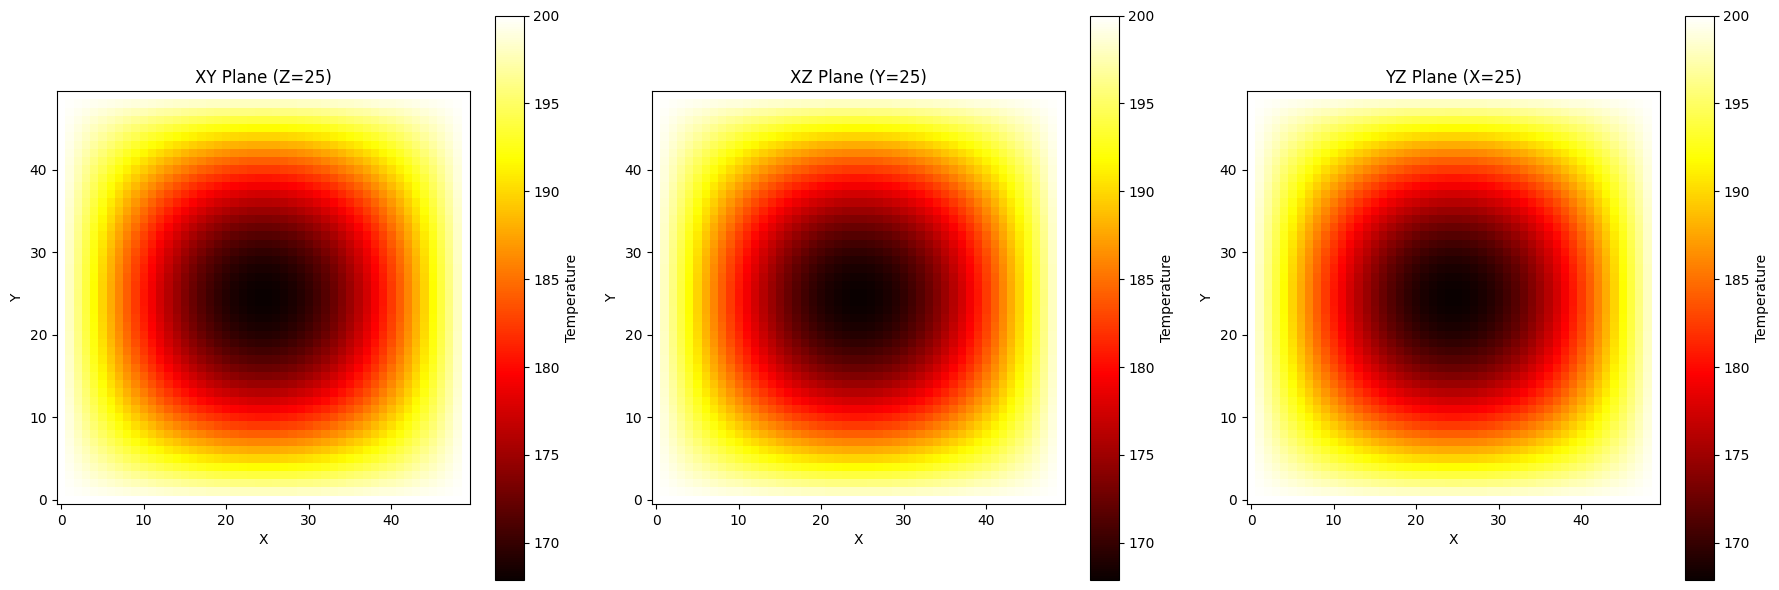

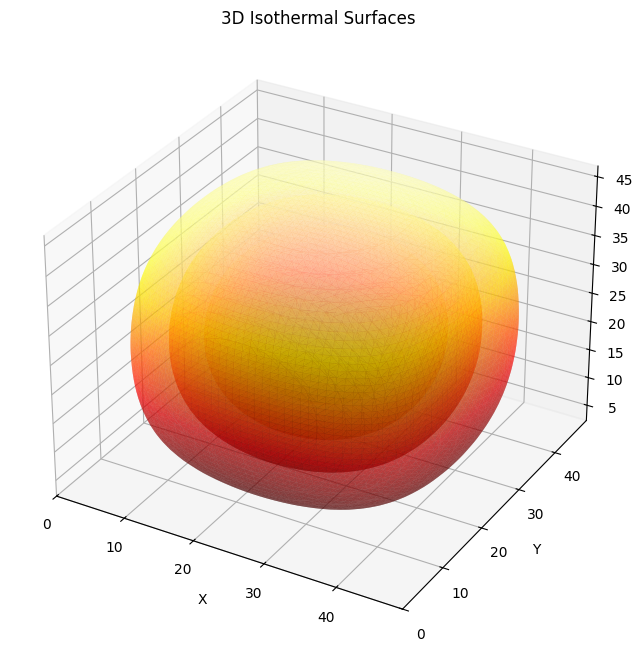

In [19]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from skimage import measure
import glob
from IPython.display import HTML
import os

def load_heat_data(filename, grid_size=50):
    """Load 3D heat data from solver output"""
    data = np.loadtxt(filename)
    u = data[:, 3].reshape((grid_size, grid_size, grid_size))
    return u

def plot_2d_slices(u):
    """Plot XY, XZ, and YZ slices directly in Colab"""
    fig, axes = plt.subplots(1, 3, figsize=(18, 6))
    mid_x, mid_y, mid_z = u.shape[0]//2, u.shape[1]//2, u.shape[2]//2

    slices = {
        'XY Plane (Z=' + str(mid_z) + ')': u[:, :, mid_z],
        'XZ Plane (Y=' + str(mid_y) + ')': u[:, mid_y, :],
        'YZ Plane (X=' + str(mid_x) + ')': u[mid_x, :, :]
    }

    vmin, vmax = np.min(u), np.max(u)
    for ax, (title, slice_data) in zip(axes, slices.items()):
        im = ax.imshow(slice_data, cmap='hot', origin='lower',
                      vmin=vmin, vmax=vmax)
        ax.set_title(title)
        ax.set_xlabel('X' if 'Y' in title else 'Y')
        ax.set_ylabel('Y' if 'Z' in title else 'Z')
        fig.colorbar(im, ax=ax, label='Temperature')

    plt.tight_layout()
    plt.show()  # Only show in notebook, no saving

def plot_3d_isosurface(u):
    """Create and show 3D isosurface plot directly"""
    fig = plt.figure(figsize=(10, 8))
    ax = fig.add_subplot(111, projection='3d')

    x, y, z = np.mgrid[0:u.shape[0], 0:u.shape[1], 0:u.shape[2]]
    levels = np.linspace(np.min(u), np.max(u), 6)[1:-1]

    for level in levels:
        verts, faces, _, _ = measure.marching_cubes(u, level=level)
        ax.plot_trisurf(verts[:, 0], verts[:, 1], faces, verts[:, 2],
                       cmap='hot', alpha=0.5, antialiased=True)

    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')
    ax.set_title('3D Isothermal Surfaces')
    plt.show()

def create_heat_animation(grid_size=50):
    """Create an animation and display it in Colab"""
    files = sorted(glob.glob("heat_step_*.txt"),
                  key=lambda x: int(x.split('_')[2].split('.')[0]))

    if not files:
        print("No time step files found! Run the solver first.")
        return

    fig, ax = plt.subplots(figsize=(8, 6))
    u = load_heat_data(files[0], grid_size)
    im = ax.imshow(u[:, :, u.shape[2]//2], cmap='hot', origin='lower')
    fig.colorbar(im, ax=ax, label='Temperature')
    title = ax.set_title(f'Heat Diffusion (Step 0)')

    def update(frame):
        u = load_heat_data(files[frame], grid_size)
        im.set_array(u[:, :, u.shape[2]//2])
        title.set_text(f'Heat Diffusion (Step {frame*100})')
        return im, title

    ani = FuncAnimation(fig, update, frames=len(files), interval=1000, blit=False)
    plt.close()  # Prevent duplicate display

    return HTML(ani.to_jshtml())  # Show directly in Colab

# Run visualization
if __name__ == "__main__":
    print("Visualizing heat equation results...")

    if not os.path.exists("heat_final.txt"):
        print("Error: heat_final.txt not found. Run the solver first.")
    else:
        u_final = load_heat_data("heat_final.txt")
        plot_2d_slices(u_final)  # Just display
        plot_3d_isosurface(u_final)  # Just display
        display(create_heat_animation())  # Show animation in Colab


---
# Wave Solver
---

In [22]:
%%writefile wave.cu
#include <iostream>
#include <fstream>
#include <cmath>
#include <cuda_runtime.h>
#include <chrono>

#define BLOCK_SIZE 8
#define gpuErrchk(ans) { gpuAssert((ans), __FILE__, __LINE__); }

inline void gpuAssert(cudaError_t code, const char *file, int line) {
    if (code != cudaSuccess) {
        fprintf(stderr, "GPUassert: %s %s %d\n", cudaGetErrorString(code), file, line);
        exit(code);
    }
}

__global__ void waveKernel(double* u, double* u_prev, double* u_next,
                          int grid_size, double c_sq_dt_sq) {
    int i = blockIdx.x * blockDim.x + threadIdx.x;
    int j = blockIdx.y * blockDim.y + threadIdx.y;
    int k = blockIdx.z * blockDim.z + threadIdx.z;

    if (i > 0 && i < grid_size-1 &&
        j > 0 && j < grid_size-1 &&
        k > 0 && k < grid_size-1) {

        int idx = i*grid_size*grid_size + j*grid_size + k;

        // Wave equation finite difference
        u_next[idx] = 2*u[idx] - u_prev[idx] + c_sq_dt_sq * (
            u[idx+grid_size*grid_size] + u[idx-grid_size*grid_size] +  // i+1, i-1
            u[idx+grid_size] + u[idx-grid_size] +                      // j+1, j-1
            u[idx+1] + u[idx-1] -                                      // k+1, k-1
            6.0*u[idx]);
    }
}

void initializeWave(double* u, int grid_size) {
    std::fill(u, u + grid_size*grid_size*grid_size, 0.0);

    // Gaussian pulse initial condition
    int center = grid_size/2;
    double sigma = 5.0;

    for (int i=center-10; i<=center+10; ++i) {
        for (int j=center-10; j<=center+10; ++j) {
            for (int k=center-10; k<=center+10; ++k) {
                double r = sqrt(pow(i-center,2) + pow(j-center,2) + pow(k-center,2));
                u[i*grid_size*grid_size + j*grid_size + k] = exp(-r*r/(2*sigma*sigma));
            }
        }
    }
}

void saveWaveData(const double* u, int grid_size, const std::string& filename) {
    std::ofstream file(filename);
    for (int i=0; i<grid_size; ++i)
        for (int j=0; j<grid_size; ++j)
            for (int k=0; k<grid_size; ++k)
                file << i << " " << j << " " << k << " "
                     << u[i*grid_size*grid_size + j*grid_size + k] << "\n";
    file.close();
}

int main() {
    const int grid_size = 50;
    const double c = 1.0;          // Wave speed
    const double dx = 1.0;
    const double dt = 0.9*dx/(c*sqrt(3.0)); // CFL condition for 3D
    const double c_sq_dt_sq = (c*c)*(dt*dt)/(dx*dx);
    const int steps = 500;
    const int save_interval = 25;

    // Allocate host memory
    double *h_u = new double[grid_size*grid_size*grid_size];
    double *h_u_prev = new double[grid_size*grid_size*grid_size];
    double *h_u_next = new double[grid_size*grid_size*grid_size];
    double *h_temp = new double[grid_size*grid_size*grid_size];

    // Initialize
    initializeWave(h_u, grid_size);
    initializeWave(h_u_prev, grid_size);

    // Allocate device memory
    double *d_u, *d_u_prev, *d_u_next;
    gpuErrchk(cudaMalloc(&d_u, grid_size*grid_size*grid_size*sizeof(double)));
    gpuErrchk(cudaMalloc(&d_u_prev, grid_size*grid_size*grid_size*sizeof(double)));
    gpuErrchk(cudaMalloc(&d_u_next, grid_size*grid_size*grid_size*sizeof(double)));

    // Copy to device
    gpuErrchk(cudaMemcpy(d_u, h_u, grid_size*grid_size*grid_size*sizeof(double),
              cudaMemcpyHostToDevice));
    gpuErrchk(cudaMemcpy(d_u_prev, h_u_prev, grid_size*grid_size*grid_size*sizeof(double),
              cudaMemcpyHostToDevice));

    // Kernel configuration
    dim3 threads(BLOCK_SIZE, BLOCK_SIZE, BLOCK_SIZE);
    dim3 blocks((grid_size+threads.x-1)/threads.x,
                (grid_size+threads.y-1)/threads.y,
                (grid_size+threads.z-1)/threads.z);

    auto start = std::chrono::high_resolution_clock::now();

    for (int t=0; t<steps; ++t) {
        waveKernel<<<blocks, threads>>>(d_u, d_u_prev, d_u_next, grid_size, c_sq_dt_sq);

        // Rotate buffers
        std::swap(d_u_prev, d_u);
        std::swap(d_u, d_u_next);

        // Save frame
        if (t%save_interval == 0) {
            gpuErrchk(cudaMemcpy(h_temp, d_u, grid_size*grid_size*grid_size*sizeof(double),
                          cudaMemcpyDeviceToHost));
            saveWaveData(h_temp, grid_size, "wave_step_" + std::to_string(t) + ".txt");
        }
    }
    gpuErrchk(cudaDeviceSynchronize());

    auto end = std::chrono::high_resolution_clock::now();
    std::chrono::duration<double> elapsed = end - start;
    std::cout << "Simulation time: " << elapsed.count() << "s\n";

    // Save final result
    gpuErrchk(cudaMemcpy(h_u, d_u, grid_size*grid_size*grid_size*sizeof(double),
                  cudaMemcpyDeviceToHost));
    saveWaveData(h_u, grid_size, "wave_final.txt");

    // Cleanup
    delete[] h_u; delete[] h_u_prev; delete[] h_u_next; delete[] h_temp;
    gpuErrchk(cudaFree(d_u)); gpuErrchk(cudaFree(d_u_prev)); gpuErrchk(cudaFree(d_u_next));

    return 0;
}

Overwriting wave.cu


In [23]:
!nvcc -O3 -arch=sm_70 -o wave_solver wave.cu
!./wave_solver

Simulation time: 1.82379s


In [25]:
!nvprof ./wave_solver

==7768== NVPROF is profiling process 7768, command: ./wave_solver
Simulation time: 1.49177s
==7768== Profiling application: ./wave_solver
==7768== Profiling result:
            Type  Time(%)      Time     Calls       Avg       Min       Max  Name
 GPU activities:   94.57%  31.345ms       500  62.689us  61.022us  64.895us  waveKernel(double*, double*, double*, int, double)
                    4.93%  1.6327ms        21  77.746us  77.374us  79.262us  [CUDA memcpy DtoH]
                    0.51%  168.12us         2  84.062us  83.902us  84.222us  [CUDA memcpy HtoD]
      API calls:   69.37%  93.836ms         3  31.279ms  4.3550us  93.752ms  cudaMalloc
                   25.97%  35.135ms        23  1.5276ms  231.47us  1.9602ms  cudaMemcpy
                    3.23%  4.3669ms       500  8.7330us  5.0780us  159.72us  cudaLaunchKernel
                    1.02%  1.3767ms         1  1.3767ms  1.3767ms  1.3767ms  cudaDeviceSynchronize
                    0.29%  385.88us         3  128.63us  35.087u

---
# Visualization
---

In [32]:
%%writefile visualize_wave_cuda.py
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from skimage import measure
import glob
import os

def load_wave_data(filename, grid_size=50):
    data = np.loadtxt(filename)
    return data[:,3].reshape((grid_size, grid_size, grid_size))

def plot_wave_slices(u, save_path=None):
    fig, axes = plt.subplots(1, 3, figsize=(18,6))

    mid = u.shape[0]//2
    slices = {
        'XY Plane': u[:,:,mid],
        'XZ Plane': u[:,mid,:],
        'YZ Plane': u[mid,:,:]
    }

    vmax = np.abs(u).max()

    for ax, (title, slice_data) in zip(axes, slices.items()):
        im = ax.imshow(slice_data, cmap='seismic', vmin=-vmax, vmax=vmax,
                      origin='lower')
        ax.set_title(title)
        fig.colorbar(im, ax=ax, label='Amplitude')

    plt.tight_layout()
    if save_path:
        plt.savefig(save_path, dpi=150, bbox_inches='tight')
    plt.show()

def plot_3d_wavefront(u, save_path=None):
    fig = plt.figure(figsize=(10,8))
    ax = fig.add_subplot(111, projection='3d')

    # Create grid
    x, y, z = np.mgrid[:u.shape[0], :u.shape[1], :u.shape[2]]
    levels = np.linspace(np.min(u), np.max(u), 6)[1:-1]
    # Plot positive and negative wavefronts
    for level in levels:
        verts, faces, _, _ = measure.marching_cubes(u, level=level)
        ax.plot_trisurf(verts[:,0], verts[:,1], faces, verts[:,2],
                       cmap='RdBu' if level>0 else 'RdBu_r',
                       alpha=0.5, antialiased=True)

    ax.set_xlabel('X'); ax.set_ylabel('Y'); ax.set_zlabel('Z')
    ax.set_title('3D Wavefronts')

    if save_path:
        plt.savefig(save_path, dpi=150, bbox_inches='tight')
    plt.show()

def create_wave_animation():
    files = sorted(glob.glob("wave_step_*.txt"),
                  key=lambda x: int(x.split('_')[2].split('.')[0]))

    if not files:
        print("No wave step files found!")
        return

    fig, ax = plt.subplots(figsize=(8,6))
    u = load_wave_data(files[0])
    vmax = np.abs(u).max()
    im = ax.imshow(u[:,:,u.shape[2]//2], cmap='seismic', vmin=-vmax, vmax=vmax)
    fig.colorbar(im, ax=ax, label='Amplitude')
    title = ax.set_title('Wave Propagation (Step 0)')

    def update(frame):
        u = load_wave_data(files[frame])
        im.set_array(u[:,:,u.shape[2]//2])
        title.set_text(f'Wave Propagation (Step {frame*25})')
        return im, title

    ani = FuncAnimation(fig, update, frames=len(files), interval=1000, blit=False)
    ani.save('wave_animation.gif', writer='pillow', fps=2, dpi=150)
    plt.close()
    print("Saved wave_animation.gif")

if __name__ == "__main__":
    print("Visualizing wave equation results...")

    if os.path.exists("wave_final.txt"):
        u = load_wave_data("wave_final.txt")
        plot_wave_slices(u, "wave_slices.png")
        plot_3d_wavefront(u, "wave_3d.png")
        create_wave_animation()
    else:
        print("Error: wave_final.txt not found. Run the solver first.")

Overwriting visualize_wave_cuda.py


In [33]:
!python visualize_wave_cuda.py

Visualizing wave equation results...
Figure(1800x600)
Figure(1000x800)
Saved wave_animation.gif


Visualizing wave equation results...


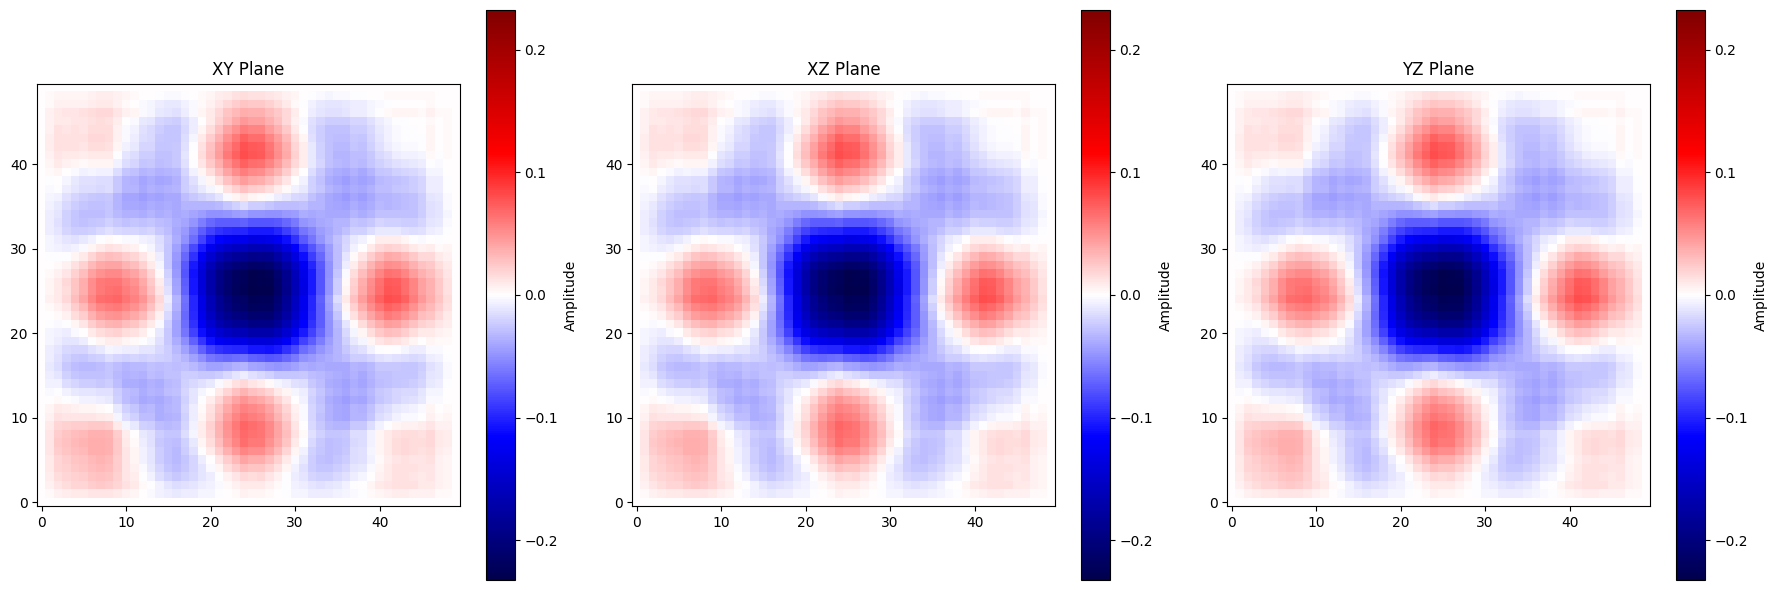

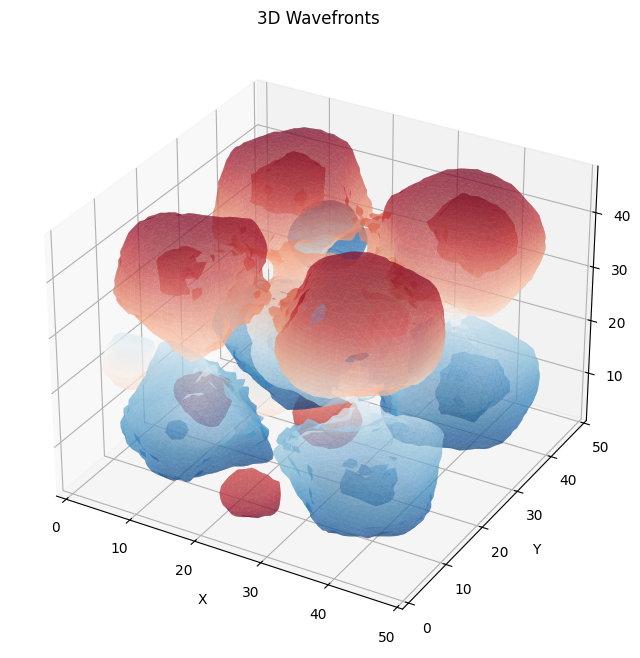

In [36]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from skimage import measure
import glob
import os
from IPython.display import HTML

def load_wave_data(filename, grid_size=50):
    data = np.loadtxt(filename)
    return data[:,3].reshape((grid_size, grid_size, grid_size))

def plot_wave_slices(u):
    fig, axes = plt.subplots(1, 3, figsize=(18,6))

    mid = u.shape[0]//2
    slices = {
        'XY Plane': u[:,:,mid],
        'XZ Plane': u[:,mid,:],
        'YZ Plane': u[mid,:,:]
    }

    vmax = np.abs(u).max()

    for ax, (title, slice_data) in zip(axes, slices.items()):
        im = ax.imshow(slice_data, cmap='seismic', vmin=-vmax, vmax=vmax,
                      origin='lower')
        ax.set_title(title)
        fig.colorbar(im, ax=ax, label='Amplitude')

    plt.tight_layout()
    plt.show()

def plot_3d_wavefront(u):
    fig = plt.figure(figsize=(10,8))
    ax = fig.add_subplot(111, projection='3d')

    # Create grid
    x, y, z = np.mgrid[:u.shape[0], :u.shape[1], :u.shape[2]]
    levels = np.linspace(np.min(u), np.max(u), 6)[1:-1]
    # Plot positive and negative wavefronts
    for level in levels:
        verts, faces, _, _ = measure.marching_cubes(u, level=level)
        ax.plot_trisurf(verts[:,0], verts[:,1], faces, verts[:,2],
                       cmap='RdBu' if level>0 else 'RdBu_r',
                       alpha=0.5, antialiased=True)

    ax.set_xlabel('X'); ax.set_ylabel('Y'); ax.set_zlabel('Z')
    ax.set_title('3D Wavefronts')

    plt.show()

def create_wave_animation():
    files = sorted(glob.glob("wave_step_*.txt"),
                  key=lambda x: int(x.split('_')[2].split('.')[0]))

    if not files:
        print("No wave step files found!")
        return

    fig, ax = plt.subplots(figsize=(8,6))
    u = load_wave_data(files[0])
    vmax = np.abs(u).max()
    im = ax.imshow(u[:,:,u.shape[2]//2], cmap='seismic', vmin=-vmax, vmax=vmax)
    fig.colorbar(im, ax=ax, label='Amplitude')
    title = ax.set_title('Wave Propagation (Step 0)')

    def update(frame):
        u = load_wave_data(files[frame])
        im.set_array(u[:,:,u.shape[2]//2])
        title.set_text(f'Wave Propagation (Step {frame*25})')
        return im, title

    ani = FuncAnimation(fig, update, frames=len(files), interval=1000, blit=False)
    plt.close()
    return HTML(ani.to_jshtml())  # Display animation inline in Colab

if __name__ == "__main__":
    print("Visualizing wave equation results...")

    if os.path.exists("wave_final.txt"):
        u = load_wave_data("wave_final.txt")
        plot_wave_slices(u)
        plot_3d_wavefront(u)
        display(create_wave_animation())  # Show animation in Colab
    else:
        print("Error: wave_final.txt not found. Run the solver first.")
